In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from IPython.display import Markdown as md
from IPython.core.display import display, HTML
np.random.seed(42)
sns.set()

Followup on the dataset I used in [ex47](ex47.ipynb).

In [2]:
affair_df = sm.datasets.fair.load_pandas().data.assign(
    was_an_affair=lambda x: (x.affairs>0.00).astype("int")
)

In [3]:
affair_df.describe(include="all")

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,was_an_affair
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374,0.322495
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374,0.467468
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848,1.000000
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991,1.000000


In [4]:
raw_mdl = smf.logit(data=affair_df, formula="was_an_affair ~ rate_marriage + age + yrs_married + children + religious + educ + occupation + occupation_husb").fit()
raw_mdl.summary()

Optimization terminated successfully.
         Current function value: 0.545314
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          was_an_affair   No. Observations:                 6366
Model:                          Logit   Df Residuals:                     6357
Method:                           MLE   Df Model:                            8
Date:                Sat, 21 Mar 2020   Pseudo R-squ.:                  0.1327
Time:                        23:25:28   Log-Likelihood:                -3471.5
converged:                       True   LL-Null:                       -4002.5
Covariance Type:            nonrobust   LLR p-value:                5.807e-224
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.7257      0.299     12.470      0.000       3.140       4.311
rate_marriage      -0.7161      0.031    -22.784      0.000      -0.778      -0.655
age                -0.0605      0.010     -5.885      0.000      -0.081      -0.040
yrs_married         0.1100      0.011     10.054      0.000       0.089       0.131
children           -0.0042      0.032     -0.134      0.893      -0.066       0.058
religious          -0.3752      0.035    -10.792      0.000      -0.443      -0.307
educ               -0.0392      0.015     -2.533      0.011      -0.070      -0.009
occupation          0.1602      0.034      4.717      0.000       0.094       0.227
occupation_husb     0.0124      0.023      0.541      0.589      -0.033       0.057
===================================================================================
"""

Out of all predictors taken without any transformations, only `children` and `occupation_husb` are non-significant. All those were considered as ordinal numeric values, which is incorrect for the `occupation_husb` variable. Let's try converting relevant variables to categorical.

In [5]:
affair_df_cat = affair_df.assign(
    rate_marriage=lambda x: x.rate_marriage.astype('category'),
    religious=lambda x: x.religious.astype('category'),
    occupation=lambda x: x.occupation.astype('category'),
    occupation_husb=lambda x: x.occupation_husb.astype('category'),
)

affair_df_cat.describe(include='all')

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,was_an_affair
count,6366.0,6366.000000,6366.000000,6366.000000,6366.0,6366.000000,6366.0,6366.0,6366.000000,6366.000000
unique,5.0,NaN,NaN,NaN,4.0,NaN,6.0,6.0,NaN,NaN
top,5.0,NaN,NaN,NaN,3.0,NaN,3.0,4.0,NaN,NaN
freq,2684.0,NaN,NaN,NaN,2422.0,NaN,2783.0,2030.0,NaN,NaN
mean,NaN,29.082862,9.009425,1.396874,NaN,14.209865,NaN,NaN,0.705374,0.322495
std,NaN,6.847882,7.280120,1.433471,NaN,2.178003,NaN,NaN,2.203374,0.467468
min,NaN,17.500000,0.500000,0.000000,NaN,9.000000,NaN,NaN,0.000000,0.000000
25%,NaN,22.000000,2.500000,0.000000,NaN,12.000000,NaN,NaN,0.000000,0.000000
50%,NaN,27.000000,6.000000,1.000000,NaN,14.000000,NaN,NaN,0.000000,0.000000
75%,NaN,32.000000,16.500000,2.000000,NaN,16.000000,NaN,NaN,0.484848,1.000000


Number of categories for categorical variables is reasonably small, which is both good for modelling and makes sense from the domain perspective.

In [6]:
cat_mdl = smf.logit(data=affair_df_cat, formula="was_an_affair ~ rate_marriage + age + yrs_married + children + religious + educ + occupation + occupation_husb").fit()
cat_mdl.summary()

Optimization terminated successfully.
         Current function value: 0.541453
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          was_an_affair   No. Observations:                 6366
Model:                          Logit   Df Residuals:                     6344
Method:                           MLE   Df Model:                           21
Date:                Sat, 21 Mar 2020   Pseudo R-squ.:                  0.1388
Time:                        23:25:28   Log-Likelihood:                -3446.9
converged:                       True   LL-Null:                       -4002.5
Covariance Type:            nonrobust   LLR p-value:                5.204e-222
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.3606      0.611      2.229      0.026       0.164       2.557
rate_marriage[T.2.0]      -0.4606      0.265     -1.738      0.082      -0.980       0.059
rate_marriage[T.3.0]      -0.8193      0.247     -3.312      0.001      -1.304      -0.334
rate_marriage[T.4.0]      -1.6974      0.243     -6.982      0.000      -2.174      -1.221
rate_marriage[T.5.0]      -2.4268      0.244     -9.942      0.000      -2.905      -1.948
religious[T.2.0]          -0.3274      0.085     -3.845      0.000      -0.494      -0.161
religious[T.3.0]          -0.6325      0.086     -7.347      0.000      -0.801      -0.464
religious[T.4.0]          -1.2911      0.132     -9.774      0.000      -1.550      -1.032
occupation[T.2.0]          0.3853      0.449      0.857      0.391      -0.496       1.266
occupation[T.3.0]          0.6891      0.443      1.554      0.120      -0.180       1.558
occupation[T.4.0]          0.4572      0.444      1.029      0.304      -0.414       1.328
occupation[T.5.0]          1.0387      0.449      2.316      0.021       0.160       1.918
occupation[T.6.0]          1.0910      0.497      2.197      0.028       0.118       2.064
occupation_husb[T.2.0]     0.1576      0.186      0.846      0.397      -0.207       0.523
occupation_husb[T.3.0]     0.2718      0.202      1.343      0.179      -0.125       0.668
occupation_husb[T.4.0]     0.1336      0.181      0.738      0.461      -0.221       0.488
occupation_husb[T.5.0]     0.1655      0.183      0.905      0.365      -0.193       0.524
occupation_husb[T.6.0]     0.1789      0.204      0.877      0.381      -0.221       0.579
age                       -0.0609      0.010     -5.896      0.000      -0.081      -0.041
yrs_married                0.1081      0.011      9.846      0.000       0.087       0.130
children                   0.0168      0.032      0.525      0.600      -0.046       0.080
educ                       0.0011      0.017      0.064      0.949      -0.033       0.035
==========================================================================================
"""

Log likelihood went a bit up, which proved that categorizing the variables was a right step. Let's take a look at variables:

* `rate_marriage` is a good predictor except the case when the rating was low. Some interaction might work out here for the low value.
* `religious` is a very strong predictor.
* `occupation` is a weak, yet adds some power to the model, whereas `occupation_husb` is still a poor one. The latter should be kicked out
* `children` is not contributing to the model again. Some normalization should be attempted.
* `educ` power went down a lot, surprisingly. Normalization has to happen here as well.

In [7]:
normalize_variable = lambda df, x: (df[x] - df[x].mean())/(2*df[x].std())

In [8]:
affair_df_nrm = affair_df_cat.assign(
    age=lambda x: normalize_variable(x, 'age'),
    yrs_married=lambda x: normalize_variable(x, 'yrs_married'),
    children=lambda x: normalize_variable(x, 'children'),
    educ=lambda x: normalize_variable(x, 'educ'),
)
affair_df_nrm.describe(include='all')

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,was_an_affair
count,6366.0,6.366000e+03,6.366000e+03,6.366000e+03,6366.0,6.366000e+03,6366.0,6366.0,6366.000000,6366.000000
unique,5.0,NaN,NaN,NaN,4.0,NaN,6.0,6.0,NaN,NaN
top,5.0,NaN,NaN,NaN,3.0,NaN,3.0,4.0,NaN,NaN
freq,2684.0,NaN,NaN,NaN,2422.0,NaN,2783.0,2030.0,NaN,NaN
mean,NaN,-1.785844e-17,3.125227e-17,-8.929221e-18,NaN,-8.036299e-17,NaN,NaN,0.705374,0.322495
std,NaN,5.000000e-01,5.000000e-01,5.000000e-01,NaN,5.000000e-01,NaN,NaN,2.203374,0.467468
min,NaN,-8.457259e-01,-5.844289e-01,-4.872349e-01,NaN,-1.196019e+00,NaN,NaN,0.000000,0.000000
25%,NaN,-5.171571e-01,-4.470685e-01,-4.872349e-01,NaN,-5.073146e-01,NaN,NaN,0.000000,0.000000
50%,NaN,-1.520808e-01,-2.066879e-01,-1.384311e-01,NaN,-4.817830e-02,NaN,NaN,0.000000,0.000000
75%,NaN,2.129956e-01,5.144541e-01,2.103726e-01,NaN,4.109580e-01,NaN,NaN,0.484848,1.000000


In [9]:
nrm_mdl = smf.logit(data=affair_df_nrm, formula="was_an_affair ~ rate_marriage:religious + age*yrs_married + children:educ + occupation").fit()
nrm_mdl.summary()

Optimization terminated successfully.
         Current function value: 0.533216
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          was_an_affair   No. Observations:                 6366
Model:                          Logit   Df Residuals:                     6337
Method:                           MLE   Df Model:                           28
Date:                Sat, 21 Mar 2020   Pseudo R-squ.:                  0.1519
Time:                        23:25:28   Log-Likelihood:                -3394.5
converged:                       True   LL-Null:                       -4002.5
Covariance Type:            nonrobust   LLR p-value:                2.099e-238
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.4870      0.682      0.714      0.475      -0.850       1.824
occupation[T.2.0]                       0.2852      0.454      0.629      0.530      -0.604       1.174
occupation[T.3.0]                       0.6215      0.448      1.387      0.165      -0.257       1.500
occupation[T.4.0]                       0.3199      0.450      0.711      0.477      -0.562       1.202
occupation[T.5.0]                       0.9500      0.454      2.094      0.036       0.061       1.839
occupation[T.6.0]                       0.9759      0.498      1.960      0.050   -7.91e-06       1.952
religious[T.2.0]                        0.5059      0.659      0.768      0.442      -0.785       1.797
religious[T.3.0]                        0.1637      0.644      0.254      0.799      -1.099       1.426
religious[T.4.0]                       -0.1533      0.994     -0.154      0.877      -2.101       1.795
rate_marriage[T.2.0]:religious[1.0]     0.1272      0.598      0.213      0.832      -1.045       1.300
rate_marriage[T.3.0]:religious[1.0]    -0.1885      0.538     -0.350      0.726      -1.243       0.866
rate_marriage[T.4.0]:religious[1.0]    -1.1475      0.527     -2.179      0.029      -2.180      -0.115
rate_marriage[T.5.0]:religious[1.0]    -1.6054      0.526     -3.051      0.002      -2.637      -0.574
rate_marriage[T.2.0]:religious[2.0]    -0.5800      0.451     -1.285      0.199      -1.465       0.305
rate_marriage[T.3.0]:religious[2.0]    -1.0782      0.425     -2.536      0.011      -1.911      -0.245
rate_marriage[T.4.0]:religious[2.0]    -1.8150      0.419     -4.332      0.000      -2.636      -0.994
rate_marriage[T.5.0]:religious[2.0]    -2.6397      0.422     -6.254      0.000      -3.467      -1.812
rate_marriage[T.2.0]:religious[3.0]    -0.5569      0.433     -1.285      0.199      -1.406       0.292
rate_marriage[T.3.0]:religious[3.0]    -0.8865      0.405     -2.192      0.028      -1.679      -0.094
rate_marriage[T.4.0]:religious[3.0]    -1.8852      0.397     -4.751      0.000      -2.663      -1.108
rate_marriage[T.5.0]:religious[3.0]    -2.5415      0.398     -6.387      0.000      -3.321      -1.762
rate_marriage[T.2.0]:religious[4.0]    -1.2652      0.951     -1.330      0.183      -3.129       0.599
rate_marriage[T.3.0]:religious[4.0]    -1.1175      0.887     -1.260      0.208      -2.856       0.621
rate_marriage[T.4.0]:religious[4.0]    -2.0898      0.871     -2.400      0.016      -3.797      -0.383
rate_marriage[T.5.0]:religious[4.0]    -3.0309      0.871     -3.479      0.001      -4.739      -1.323
age                                    -0.6921      0.137     -5.047      0.000      -0.961      -0.423
yrs_married                             1.9885      0.143     13.940      0.000       1.709       2.268
age:yrs_married                        -1.3615      0.141     -9.659      0.000      -1.638      -1.085
children:educ    

Let's stick to this model as it provides the strongest performance out of all tested.

* only two types of occupations matter significantly.
* the religiousness of a person has significance only in combination with a marriage_rate
* age and yrs_married contribute to the model, but have opposite signs, so long-running early marriages are the most susceptible to affairs, which is also supported by the sign of the age*yrs_married interaction
* as we saw earlier, both number of children and education factors are not significant, yet in combination the contribute to the model in a significant way. If both are high enough, the probability of an affair goes up.

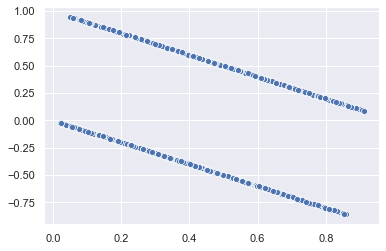

In [10]:
pred_values = nrm_mdl.predict(affair_df_nrm)
sns.scatterplot(x = pred_values, y = affair_df_nrm.was_an_affair - pred_values);

In [11]:
def ci(data):
    return np.mean(data)

bins=len(pred_values) / 50

bin_mean, bin_x, _ = binned_statistic(
    x=pred_values,
    values=affair_df_nrm.was_an_affair - pred_values,
    statistic='mean',
    bins=bins
)

bin_cnt, _, _ = binned_statistic(
    x=pred_values,
    values=affair_df_nrm.was_an_affair - pred_values,
    statistic='count',
    bins=bins
)


binned_residuals = pd.DataFrame({
    'binned_count': bin_cnt, 
    'binned_mean': bin_mean, 
    'prob': bin_x[:-1] 
}).assign(
    binned_ci_upper=lambda x: 2*np.sqrt(x.prob*(1-x.prob)/x.binned_count),
    binned_ci_lower=lambda x: -2*np.sqrt(x.prob*(1-x.prob)/x.binned_count)
)

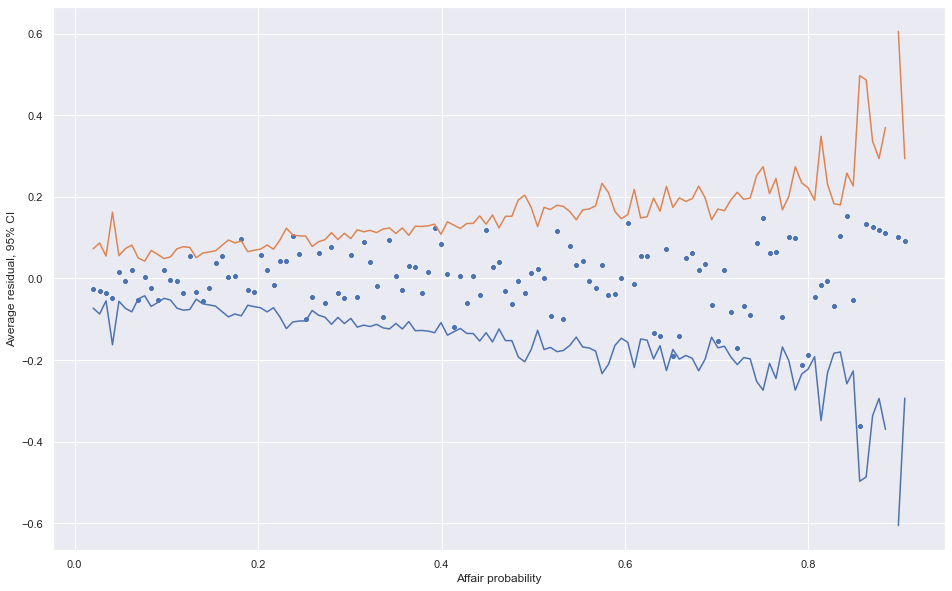

In [12]:
ax = sns.scatterplot(
    data=binned_residuals, x='prob', y='binned_mean'
)
sns.lineplot(data=binned_residuals, x='prob', y='binned_ci_lower', ax=ax)
sns.lineplot(data=binned_residuals, x='prob', y='binned_ci_upper', ax=ax)
ax.set_ylabel('Average residual, 95% CI')
ax.set_xlabel('Affair probability');
ax.figure.set_size_inches(16, 10)

Residuals seem to get positively biased towards the high probability zone. Let's check the distribution.

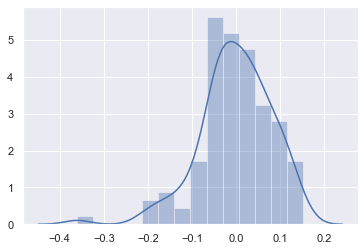

In [13]:
sns.distplot(bin_mean, kde=True)

In [14]:
err_vals = pd.DataFrame({
    'predicted': pred_values,
    'observed': affair_df_nrm.was_an_affair
}).assign(
    null_mdl=0,
    is_error=lambda x: (((x.predicted>=0.5) & (x.observed==0)) | ((x.predicted<0.5) & (x.observed==1))).astype('int'),
    null_error=lambda x: (((x.null_mdl>=0.5) & (x.observed==0)) | ((x.null_mdl<0.5) & (x.observed==1))).astype('int')
)[['is_error', 'null_error']].mean()
md(f"The model error rate is {err_vals['is_error']}, whereas the constant-model error rate is {err_vals['null_error']}. The model performs better than a constant by {err_vals['null_error'] - err_vals['is_error']}")

The model error rate is 0.2673578385171222, whereas the constant-model error rate is 0.3224945020420987. The model performs better than a constant by 0.05513666352497648

In [15]:
md(f"The model deviance is {-2 * nrm_mdl.llf}, whereas the constant-model deviance is {-2 * nrm_mdl.llnull}. The deviance improvement is {(nrm_mdl.llnull - nrm_mdl.llf) / nrm_mdl.llf} which is pretty significant.")

The model deviance is 6788.905814149819, whereas the constant-model deviance is 8005.059932187134. The deviance improvement is 0.1791384578502383 which is pretty significant.